In [1]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py', 'wb').write(src)

Saving utils.py to utils.py


38073

# 1. Settings

## 1) Important required libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

## 2) Hyperparameter

In [3]:
batch_size = 16
learning_rate = 0.0001
epoch = 20

n_node = 1024
dropratio = 0.5

imgsize = 256

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Data Loader

## 트레이닝 데이터

In [5]:
img_dir = "/content/drive/MyDrive/[실습05]/animal/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size = batch_size,
                             shuffle = True, num_workers = 2)

84


## 고정된 데이터 셋

In [6]:
img_dir = "/content/drive/MyDrive/[실습05]/animal/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))

dev_batch = data.DataLoader(dev_data, batch_size = batch_size,
                             shuffle = True, num_workers = 2)

In [7]:
img_dir = "/content/drive/MyDrive/[실습05]/animal/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))

test_batch = data.DataLoader(test_data, batch_size = batch_size,
                             shuffle = True, num_workers = 2)

In [8]:
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# of classes: 2
['rabbits', 'squirrels']
{'rabbits': 0, 'squirrels': 1}
84
Training: 84, Dev: 28, Test: 28


(None,)

In [9]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['rabbits', 'squirrels']
['rabbits', 'squirrels']
['rabbits', 'squirrels']


# 3. Model

## 1) Pretrained VGG Model

In [10]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

## 2) Customized Fully Model

In [11]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG,self).__init__()
        
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn.Linear(n_node, nclass),
        )
        for m in self.layer1.modules():
          if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight.data)
            m.bias.data.fill_(0)
          if isinstance(m, nn.Linear):
            init.kaiming_normal(m.weight.data)
            m.bias.data.fill_(0)
    
    def forward(self,x):
            out=self.layer0(x)
            out=out.view(out.size(0),-1)
            out=self.layer1(out)
            
            return out

## 3) Model on GPU

In [12]:
#fsize = int(imgsize/32)
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [13]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss

In [14]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

# 5. Train

In [15]:
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train==False):
    netname = '/content/drive/MyDrive/[실습05]/nets/rabbitsquirrel_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node; %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
         %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = '/content/drive/MyDrive/[실습05]/nets/rabbitsquirrel_vgg19'
    
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img, label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i == epoch - 1):
            torch.save(model, netname+'_%d.plk'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            model.eval()
            
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correnct of train: %.2f, dev: %.2f, test: %.2f, "
                 %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node; 1024, dropratio: 0.50
Correct of train: 48.81, dev: 50.00, test: 42.86
0..

[0/20] loss: 1.169, 
Correnct of train: 66.67, dev: 39.29, test: 57.14, 
time: 23.36 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 1.505, 
Correnct of train: 83.33, dev: 67.86, test: 71.43, 
time: 255.32 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.902, 
Correnct of train: 83.33, dev: 75.00, test: 67.86, 
time: 465.25 sec..
Total time: 465.25 sec


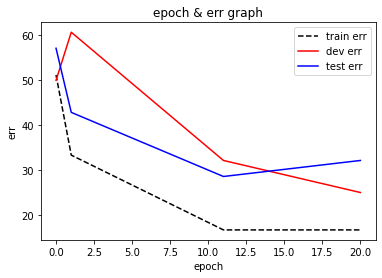

In [16]:
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

# 6. Evaluation for dev & test data

Normalized confusion matrix


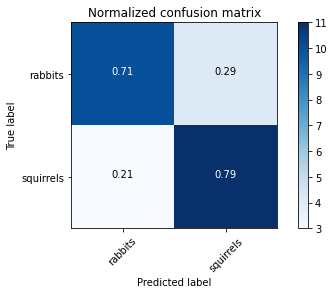

Confusion matrix, without normalization


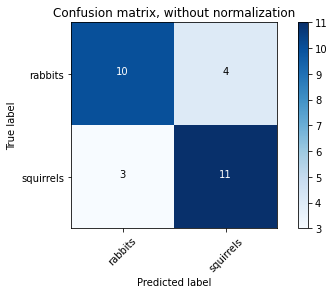

	 acc  |	 pre  |	 rec  |	 f1
 rabbits: 0.75 |	 0.77 |	 0.71 |	 0.74
 squirrels: 0.75 |	 0.73 |	 0.79 |	 0.76
*accuracy: 0.75, precision: 0.75, recall: 0.75, *f1 score: 0.75
[AP]
rabbits: 0.76
squirrels: 0.78

[mAP] 0.772
[miAP] 0.875


(array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1]),
 array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1]),
 array([0.7015453 , 0.86965621, 0.56556928, 0.59603745, 0.77618867,
        0.68486679, 0.74428988, 0.7392416 , 0.72395474, 0.51940089,
        0.54325253, 0.56351388, 0.69034773, 0.64926749, 0.701805  ,
        0.63387799, 0.63664198, 0.59897345, 0.91184163, 0.93327838,
        0.50496459, 0.641976  , 0.90104491, 0.69030446, 0.75083011,
        0.58251667, 0.58451515, 0.90917838]))

In [17]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


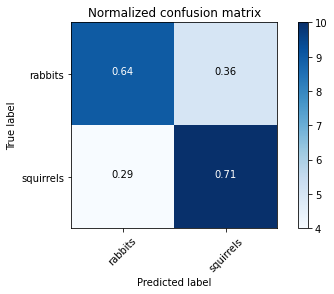

Confusion matrix, without normalization


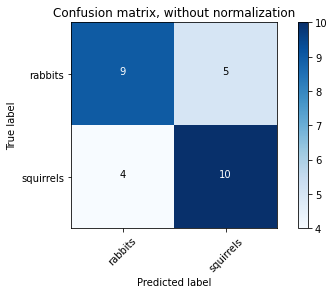

	 acc  |	 pre  |	 rec  |	 f1
 rabbits: 0.68 |	 0.69 |	 0.64 |	 0.67
 squirrels: 0.68 |	 0.67 |	 0.71 |	 0.69
*accuracy: 0.68, precision: 0.68, recall: 0.68, *f1 score: 0.68
[AP]
rabbits: 0.81
squirrels: 0.69

[mAP] 0.753
[miAP] 0.839


In [18]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: rabbits
 True predicted images/total rabbits category: 10 / 14
Predicted probability:
[0.641976 0.358024]


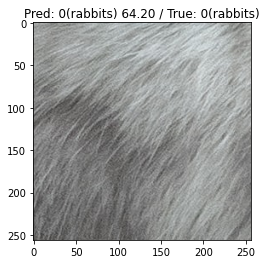

Predicted probability:
[0.5194009 0.4805991]


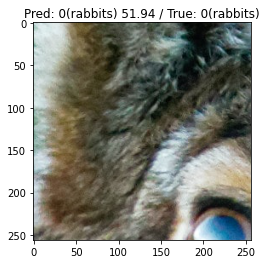

 False predicted images/total rabbits category: 4 / 14
Predicted probability:
[0.36612204 0.633878  ]


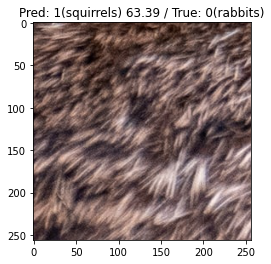

Predicted probability:
[0.35073254 0.6492675 ]


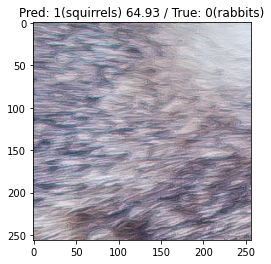

Category: squirrels
 True predicted images/total squirrels category: 11 / 14
Predicted probability:
[0.27604526 0.72395474]


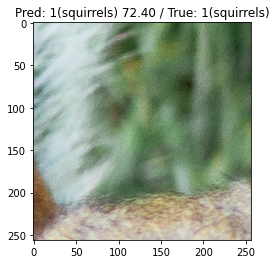

Predicted probability:
[0.36335802 0.636642  ]


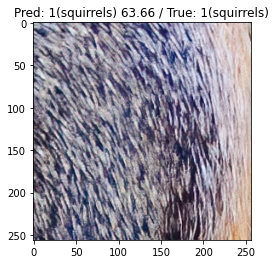

 False predicted images/total squirrels category: 3 / 14
Predicted probability:
[0.7761887 0.2238113]


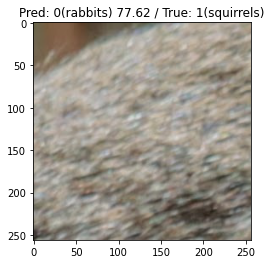

Predicted probability:
[0.5825167  0.41748333]


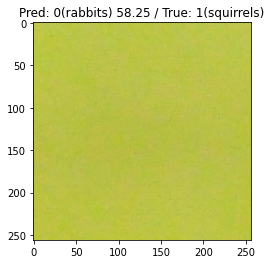

In [19]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)